## 1. Introduction
이번엔 <Titanic Top 4% with ensemble modeling>이란 제목의 Kaggle 노트북에 대해 공부해보자. 이 노트북은 Yassine Ghouzam이 작성한 노트북으로 처음 kaggle에 작성한 노트북이라 한다.(부럽..)  

이 노트북은 크게 세 개의 과정을 거친다.  
- 피처 분석(Feature analysis)
- 피처 엔지니어링(Feature engineering)
- 모델링(Modeling)  

Titanic 데이터는 아래와 같이 구성되어 있다.
- PassengerId: 탑승자 데이터 일련번호
- Survived: 생존여부, 0 = 사망, 1 = 생존
- Pclass: 티켓의 선실 등급, 1 = 일등석, 2 = 이등석, 3 = 삼등석
- Sex: 탑승자 성별
- Name: 탑승자 이름
- Age: 탑승자 나이
- SibSp: 같이 탑승한 형제, 자매 또는 배우자 인원 수
- Parch: 같이 탑승한 부모님 또는 자녀 인원 수
- Ticket: 티켓 번호
- Fare: 요금
- Cabin: 선실 번호
- Embarked: 탑승 항구, C = Cherbourg, Q = Queenstown, S = Southampton

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

`sns.set(style='white', context='notebook', palette='deep')`
- style: 배경색
- context: 그래프의 배율 조정으로, {paper, notebook, talk, poster}중에 설정 할 수 있다.
- palette: 어떤 색상 모음을 사용할지 선택하며, {deep, muted, pastel, bright, dark, colorblind}를 기본 팔레트로 제공한다.  

[palette의 종류](https://seaborn.pydata.org/tutorial/color_palettes.html)

## 2. Load and Check Data
### 2.1 Load Data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test['PassengerId']

### 2.2 Outlier Detection
여기서 사회조사분석사를 공부하면서 배웠던 개념인 이상치(Outlier)에 대해 나온다. 먼저 사분위수는 데이터 표본을 4개의 동일한 부분(25%, 50%, 75%)으로 나눈 값이고, 그 중 제 1 사분위수(Q1, 데이터 25%가 이 값보다 작거나 같음), 제 3 사분위수(Q3, 데이터 75%가 이 값보다 작거나 같음)로 IQR(Q3 - Q1)을 구한다. 이때 우리는 **Q1 - 1.5 * IQR** 보다 작거나 **Q3 + 1.5 * IQR** 보다 큰 값을 이상치라고 한다.  

필자는 Tukey의 범위 검정 개념을 이용해서 **Age, SibSp, Parch, Fare**에 대한 이상치 분석을 통해 3개이상의 이상치를 가진 사람들을 알아본다.  

**from collections import Counter**는 컨테이너에 동일한 값의 자료가 몇 개인지를 파악하는데 사용하는 객체로 `collections.Counter()`의 결과값은 딕셔너리 형태로 출력된다.  
ex) lst = ['aa', 'cc', 'dd', 'aa', 'bb', 'ee']의 요소 개수를 `collections.Counter()`를 이용하여 구할 수 있다.
Output: **Counter({'aa': 2, 'cc': 1, 'dd': 1, 'bb': 1, 'ee': 1})**  

In [3]:
features = ['Age', 'SibSp', 'Parch', 'Fare']
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

Outliers_to_drop = detect_outliers(train, 2, features)
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


3개 이상의 이상치를 갖는 10개의 데이터는 볼 수 있다. 28, 89, 342번 승객은 높은 티켓 가격을, 다른 승객들은 높은 SibSp 값을 가지고 있다. 이 승객들을 제외하자.  
`reset_index`는 인덱스를 리셋시키고 `drop=True`는 디폴트는 False로, True는 기존 인덱스를 버리고 재배열해준다.

In [4]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

### 2.3 Joining Train and Test Set
`concat()`은 데이터 속성 형태가 동일한 데이터 세트를 합칠 때 사용한다. *axis* 가 0이면 위, 아래로 합치고 1이면 좌, 우로 합친다.

In [5]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### 2.4 Check for Null and Missing Values


In [6]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

**Age**와 **Cabin**에 많은 양의 결측값이 있는 것을 알 수 있고, **Survived**의 결측값은 Test dataset에서 온 것으로 확인된다.(테스트 세트의 Survived열은 비어있어서 NaN으로 대체됨.)

In [7]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [10]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature Analysis
### 3.1 Numerical values
서수형 값들에 대해 상관관계 분석을 진행한다.  
`annot=True` 파라미터는 각 박스 안에 상관계수를 표시하는지를 결정한다.

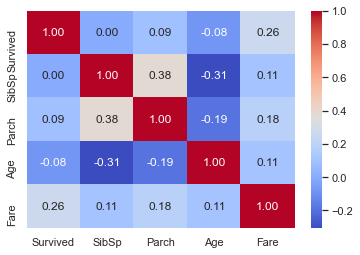

In [11]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

**Fare** 만이 생존에 대해 상관관계를 가지지만 이것이 다른 피처들이 쓸모없다는 것을 의미하진 않는다. 각 특징들에 대해 분석해 보자.  

#### SibSp

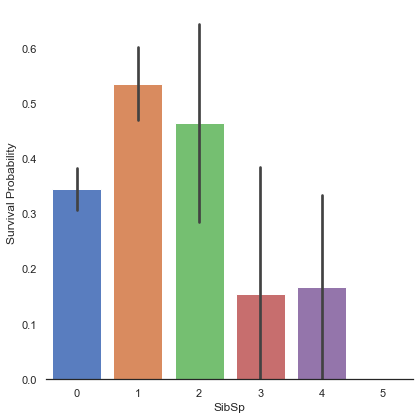

In [12]:
g = sns.factorplot('SibSp', 'Survived', data=train, kind='bar', size=6, palette='muted')
# despine은 y축의 선을 없앨 것인지를 결정한다.
g.despine(left=True)
g.set_ylabels('Survival Probability')

형제/자매의 수가 적은 사람들(1, 2)의 생존률이 더 높은 것으로 관찰된다.  

#### Parch

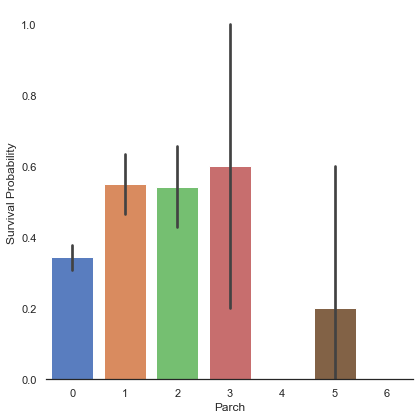

In [13]:
g = sns.factorplot('Parch', 'Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g.set_ylabels('Survival Probability')

부모/자식의 수가 3인 사람의 생존률이 가장 높게 나타났고, 아예 없거나 5명인 대가족은 생존률이 낮게 나타났다.  

#### Age
`sns.FacetGrid`를 사용하면 여러 개의 그래프를 그릴 수 있다. 여기선 *Survived*가 0과 1일때의 히스토그램을 그렸다. 

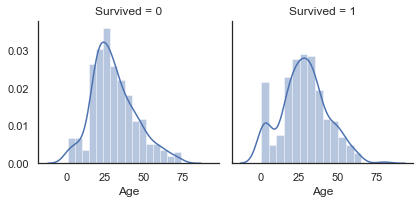

In [14]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

Age의 분포는 가우스 분포(정규분포)의 형태를 띄며, 60-80세의 생존률이 낮고, 어린 승객의 생존률이 높은 것을 알 수 있다.  
비록 Age와 Survived는 상관관계가 없지만, 연령별 승객의 생존률 차이가 존재하는 것을 알 수 있다. 좀 더 확실하게 비교하기위해 데이터의 분포를 확인하는 커널밀도추정(Kernel Density Estimater) 그래프를 그려보자.

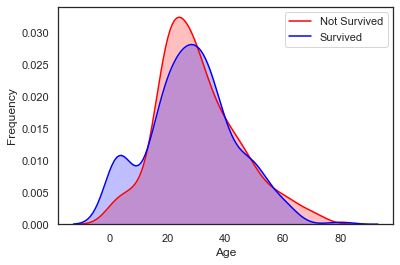

In [15]:
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g.legend(['Not Survived', 'Survived'])

두 밀도 그래프를 겹쳐본 결과 0-5세의 아이들의 생존률이 높게 나타나는 것을 알 수 있다.

#### Fare

In [16]:
dataset['Fare'].isnull().sum()

1

코드 실행 결과 Fare의 결측값은 1개이므로 그 값은 중간값으로 대체

In [17]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

`skew()`는 비대칭도(왜도)인 skewness를 뜻한다.  
일반적으로 왜도는 첨도와 같이 얘기하는데 첨도는 뾰족한 정도, 왜도는 비대칭 정도를 의미한다.  
왜도의 기준은 0, 첨도의 기준은 3으로 정규분포와 비교한다.  
- 왜도가 0보다 크면 오른쪽으로 긴 꼬리를 갖는다. 
- 왜도가 0보다 작으면 왼쪽으로 긴 꼬리를 갖는다.
- 첨도가 3보다 크면 peak점이 뾰족하다.
- 첨도가 3보다 작으면 peak점이 덜 뾰족하다.

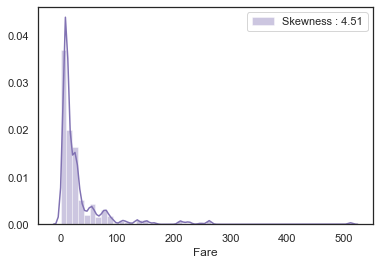

In [18]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g.legend(loc='best')

**Fare**의 분포가 매우 비대칭인 것을 알 수 있는데, 만약 이대로 모델에 넣어준다면 모델이 몇 개 없는 *outlier*에 민감하게 반응하면, 잘못 학습할 수도 있다. 그래서 **Fare**에 **log** 를 취한 후 다시 확인해보도록 하자. 

In [19]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

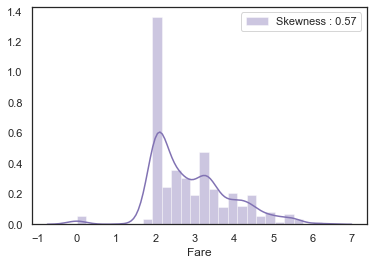

In [20]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g.legend(loc='best')

왜도의 값이 *4.51* 에서 *0.57* 로 눈에 띄게 줄어든 것을 알 수 있다.  
  
### 3.2 Categorical Values
#### Sex
위에서 서수형 데이터들을 보았으니 이번엔 카테고리형 데이터들에 대해 알아보자.

Text(0, 0.5, 'Survival Probability')

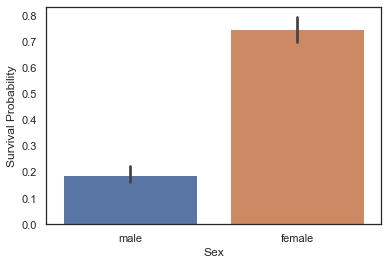

In [21]:
g = sns.barplot('Sex', 'Survived', data=train)
g.set_ylabel('Survival Probability')

In [22]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남성의 생존률보다 여성의 생존률이 확연하게 높은 것을 알 수 있다. **Sex**는 생존 예측의 중요한 피처가 될 것이라고 생각할 수 있다.  
#### Pclass

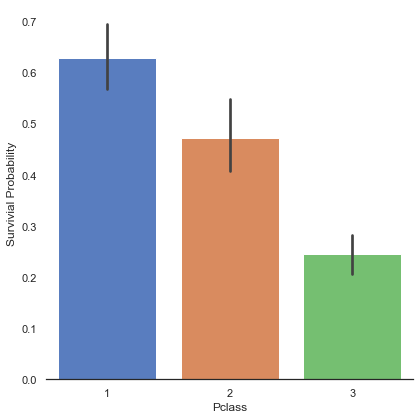

In [23]:
g = sns.factorplot('Pclass', 'Survived', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g.set_ylabels('Survivial Probability')

**Pclass**가 낮을수록, 즉 좋은 일등석에 가까울수록 생존률이 높아지는 것을 알 수 있다. 이번엔 성별별, 각 클래스별 생존률을 알아보자.

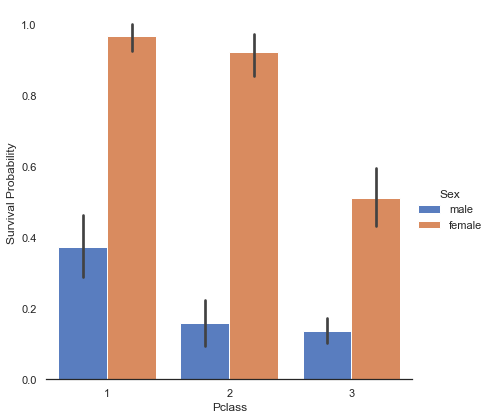

In [24]:
g = sns.factorplot('Pclass', 'Survived', hue='Sex', data=train, kind='bar', size=6, palette='muted')
g.despine(left=True)
g.set_ylabels('Survival Probability')

남성, 여성에 상관없이 1등석과 2등석의 생존률이 3등석에 비해 높다는 것을 알 수 있다.  
#### Embarked

In [25]:
dataset['Embarked'].isnull().sum()

2

**Embarked**의 Null 값이 2개밖에 없고 대부분 *Southampton* 에서 탑승했으므로 Null 값을 "S"로 대체한다.

In [26]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

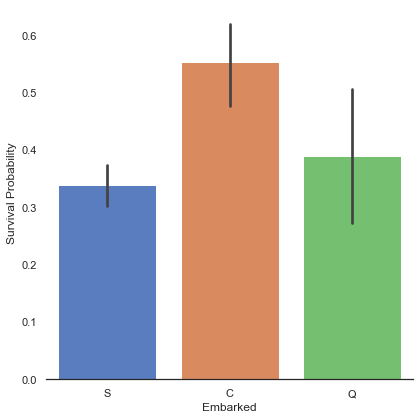

In [27]:
g = sns.factorplot('Embarked', 'Survived', data=train, size=6, kind='bar', palette='muted')
g.despine(left=True)
g.set_ylabels('Survival Probability')

**Cherbourg(C)**에서 탑승한 승객의 생존률이 높게 나타났다. 필자는 여기서 C에서 탑승한 승객의 생존률이 높은 이유를 1등석 승객이 많아서 일것으로 가정하고 아래 비교 그래프를 그린다.

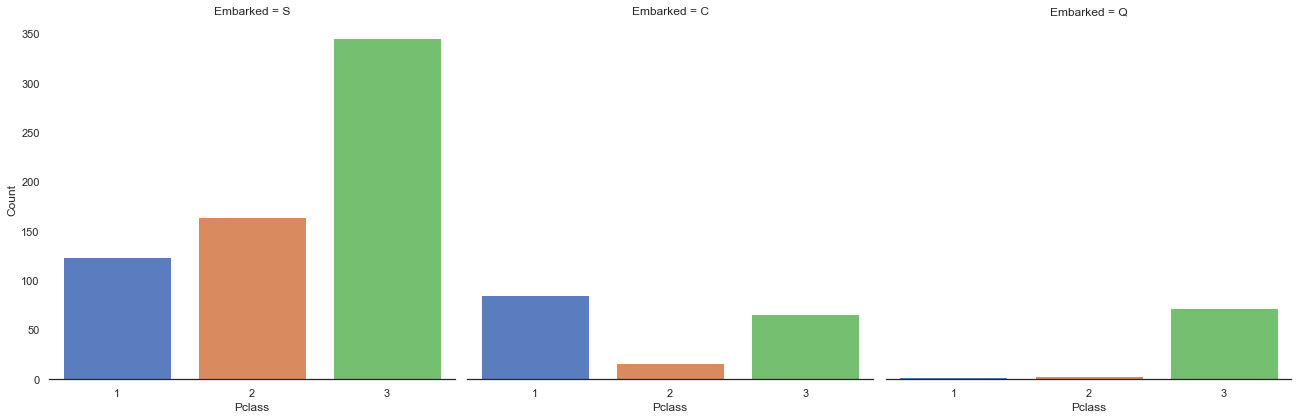

In [28]:
g = sns.factorplot('Pclass', col='Embarked', data=train, size=6, kind='count', palette='muted')
g.despine(left=True)
g.set_ylabels('Count')

**Southampton(S)**와 **Queenstown(Q)**에서 탑승한 승객들은 대부분 3등석 승객이지만, **Cherbourg(C)**에서 탑승한 승객은 1등석 승객이 더 많았다.  
## 4. Filling Missing Values
### 4.1 Age
위에서 **Age**에는 256개의 Null 데이터가 존재하는 것을 확인하였다. 존재하는 Null 값들을 채우기위해 *Sex, Parch, Pclass, SibSp* 중 어떤 변수가 가장 상관관계가 있는지 확인해보자.


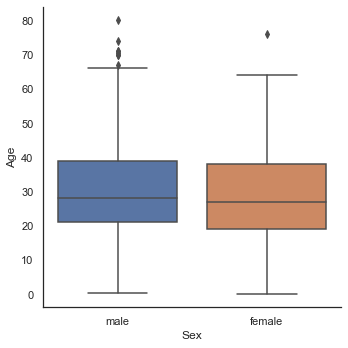

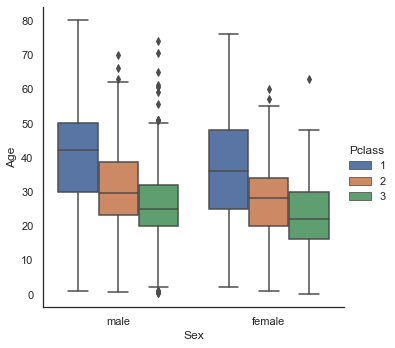

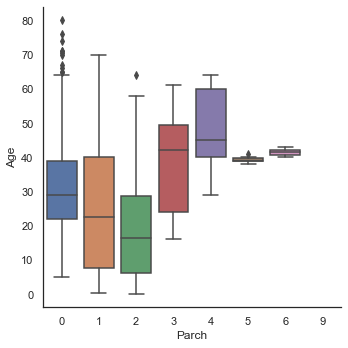

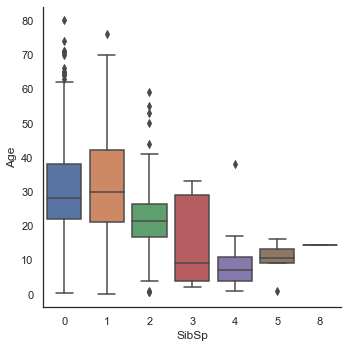

In [29]:
sns.factorplot('Sex', 'Age', data=dataset, kind='box')
sns.factorplot('Sex', 'Age', hue='Pclass', data=dataset, kind='box')
sns.factorplot('Parch', 'Age', data=dataset, kind='box')
sns.factorplot('SibSp', 'Age', data=dataset, kind='box')

1. **Sex**는 남, 녀 모두에서 비슷한 양상을 보여 **Age**를 예측하기 중요한 정보는 아니라고 판단된다. 
2. 1등급 승객이 2등급 승객보다 나이가 많고, 2등급 승객이 3등급 승객보다 나이가 많은 것으로 나타난다.
3. 부모/자식을 많이 가진 승객일수록 나이가 많다.
4. 형제/자매를 많이 가진 승객일수록 나이가 어리다.  

성별이 문자형 데이터이므로 숫자형으로 변환하고 상관관계 분석을 해보자.

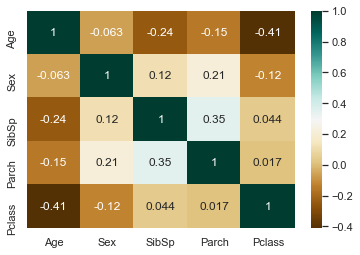

In [30]:
dataset['Sex'] = dataset['Sex'].map({"male": 0, "female": 1})
sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

상관관계 분석에 따르면 **Age**는 *Sex* 와 상관관계가 없고, *SibSp, Parch, Pclass* 와 부정적 상관관계를 갖는다. 위에서 부모/자식을 많이 가진 승객일수록 나이가 많다고 나타났는데 일반적인 상관관계는 부정적이다.  
상관관계가 있다고 나온 *SibSp, Parch, Pclass* 를 이용해서 **Age**의 Null 값을 채우자.

In [31]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_med
    else:
        dataset['Age'].iloc[i] = age_pred

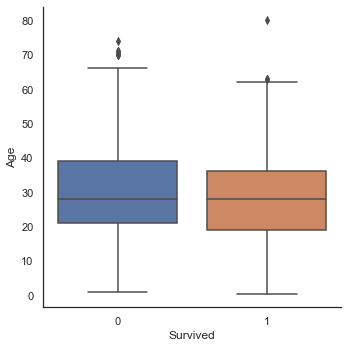

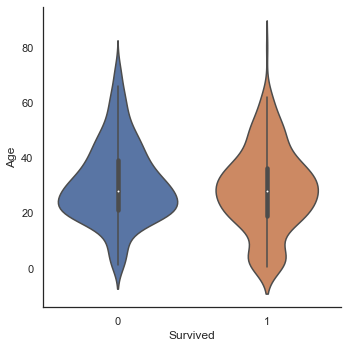

In [32]:
sns.factorplot('Survived', 'Age', data=train, kind='box')
sns.factorplot('Survived', 'Age', data=train, kind='violin')

생존하지 못한 승객과 생존한 승객의 연령의 중간값은 거의 차이가 없다. 하지만 *violin* 그래프에서 여전히 아이들의 생존률은 높은 것으로 나타났다.  
## 5. Feature Engineering
### 5.1 Name/Title

In [33]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

이름은 *Mr, Mrs, Miss* 등의 정보를 담고있고, 이 정보를 추출해내어서 모델에 추가해보는 것도 가능할 것 같다.

In [34]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

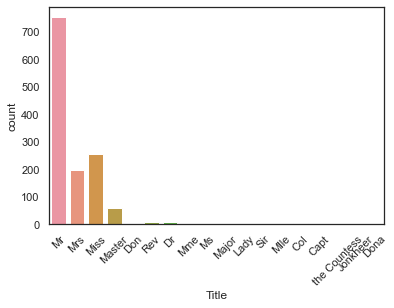

In [35]:
g = sns.countplot('Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

17개의 **Title** 이 나왔는데 이것들을 4가지 카테고리(Master, Miss~Mrs, Mr, Rare)로 바꿀 수 있다.

In [36]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

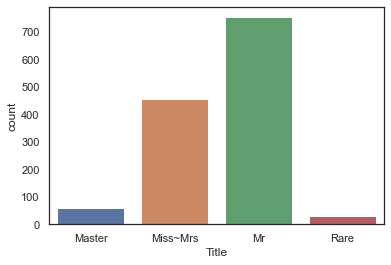

In [37]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss~Mrs', 'Mr', 'Rare'])

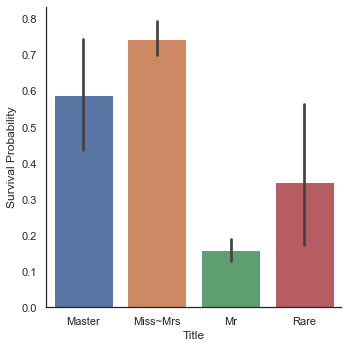

In [38]:
g = sns.factorplot('Title', 'Survived', data=dataset, kind='bar')
g = g.set_xticklabels(['Master', 'Miss~Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('Survival Probability')

여성의 생존률이 역시 가장 높으며 Rare로 분류한 승객들의 생존률도 꽤나 높은 것을 볼 수 있다. 이제 이름은 필요없으니 삭제한다.

In [39]:
dataset.drop(labels=['Name'], axis=1, inplace=True)

### 5.2 Family Size
필자는 대가족의 경우 대피가 더 힘들 것이라 생각해서 *SibSp, Parch, 1(자기자신)* 을 합친 **Fsize(Family Size)** 피처를 만든다.

In [40]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

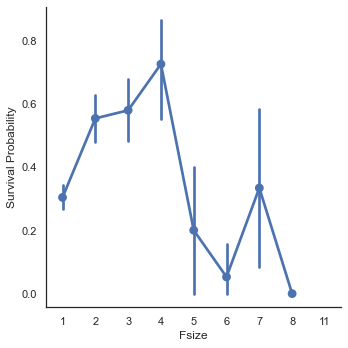

In [41]:
g = sns.factorplot('Fsize', 'Survived', data=dataset)
g.set_ylabels('Survival Probability')

필자의 예상대로 대가족인 경우 생존률이 낮아짐을 알 수 있다. 그리고 여기서 4개의 카테고리로 나누기로 한다.

In [42]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

Text(0, 0.5, 'Survival Probability')

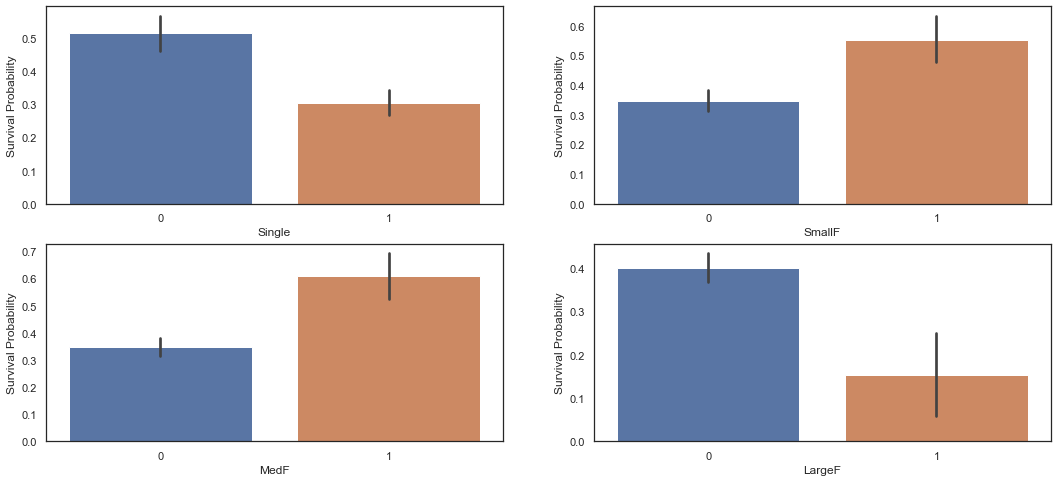

In [43]:
f, ax = plt.subplots(2, 2, figsize=(18, 8))
sns.barplot('Single', 'Survived', data=dataset, ax=ax[0, 0])
ax[0, 0].set_ylabel('Survival Probability')
sns.barplot('SmallF', 'Survived', data=dataset, ax=ax[0, 1])
ax[0, 1].set_ylabel('Survival Probability')
sns.barplot('MedF', 'Survived', data=dataset, ax=ax[1, 0])
ax[1, 0].set_ylabel('Survival Probability')
sns.barplot('LargeF', 'Survived', data=dataset, ax=ax[1, 1])
ax[1, 1].set_ylabel('Survival Probability')

*Small, Medium Family* 의 생존률이 *Single, Large Family* 의 생존률보다 높은 것을 알 수 있다.  
**Title** 과 **Embarked** 에 One-Hot Encoding을 하자

In [44]:
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


### 5.3 Cabin

In [45]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [46]:
dataset['Cabin'].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [47]:
dataset['Cabin'].isnull().sum()

1007

**Cabin**에 292개의 값이 있고 Null 값이 1007개 있는 것으로 확인된다. 여기서 필자는 **Cabin**의 앞 글자(알파벳)에 따른 생존률을 알아보려한다.

In [48]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [49]:
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

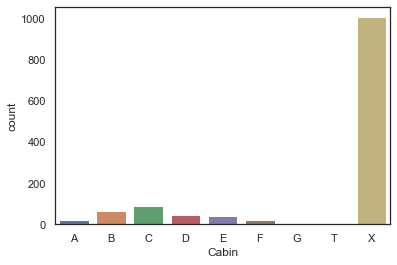

In [50]:
sns.countplot(dataset['Cabin'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

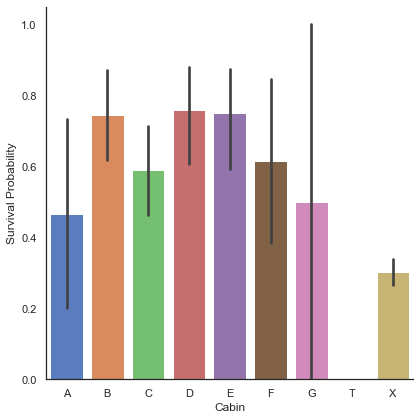

In [51]:
g = sns.factorplot('Cabin', 'Survived', data=dataset, kind='bar', size=6, palette='muted', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g.set_ylabels('Survival Probability')

여기서 우리는 선실이 미확인된 승객(X)보단 *B, C, D, E, F* 선실 승객의 생존률이 더 높은 것을 알 수 있다. **Cabin** 에 대해서도 One-Hot encoding을 한다.

In [52]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

### 5.4 Ticket

In [53]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

필자는 Ticket의 숫자부분보다 앞부분이 더 많은 정보를 가지고 있을 것이라 판단하고 앞글자만 잘라내기로 한다.  
- isalpha: 문자열인지 아닌지를 True, False로 리턴
- isdigit: 숫자인지 아닌지를 True, False로 리턴
- strip: 양쪽의 공백 제거

In [54]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0])
    else:
        Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

**Ticket** 과 **Pclass** 에 대해 One-Hot encoding을 진행한다. **Pclass** 는 그 전에 *categorical value* 로 바꿔준다. 그리고 필요없는 정보인 **PassengerId** 를 삭제한다.

In [55]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')

In [56]:
dataset.drop(labels=['PassengerId'], axis=1, inplace=True)

In [57]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


이것으로 모든 데이터 처리는 끝났다.  

### 6. Modeling

In [58]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

In [59]:
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels=['Survived'], axis=1)

### 6.1 Simple Modeling
#### 6.1.1 Cross Validate Models
유명한 10개의 분류기를 비교하고 Stratified KFold로 교차 검증을 진행한다.
- SVC
- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceptron(neural network)
- KNN
- Logistic Regression
- Linear Discriminant Analysis

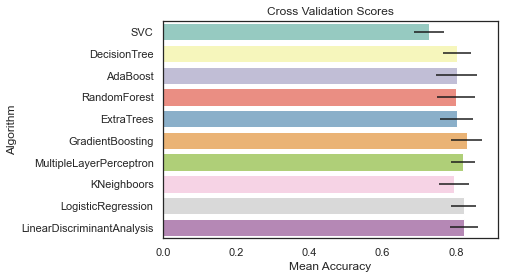

In [60]:
kfold = StratifiedKFold(n_splits=10)
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std, 'Algorithm': ["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

# **kwargs의 의미는 어떤 값을 넣을진 모르는데 변수가 딕셔너리 형태로 입력되는 것, *args는 변수가 튜플 형태로 입력되는 것
g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross Validation Scores')

필자는 여기서 **SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting** 을 앙상블 모델링을 위해 선택한다.  
#### 6.1.2 Hyperparameter Tunning for Best Models


In [61]:
# AdaBoost
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {'base_estimator__criterion': ['gini', 'entropy'],
                 'base_estimator__splitter': ['best', 'random'],
                 'algorithm': ['SAMME', 'SAMME.R'],
                 'n_estimators': [1, 2],
                 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}
# verbose=0(default)면 메시지 출력 안함, 1이면 간단한 메시지 출력, 2면 하이퍼 파라미터별 메시지 출력
gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsadaDTC.fit(X_train, Y_train)
ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 280 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    3.9s finished


0.8241317671092953

In [62]:
# ExtraTrees
ExtC = ExtraTreesClassifier()
ex_param_grid = {"max_depth": [None],
                "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10],
                "min_samples_leaf": [1, 3, 10],
                'bootstrap': [False],
                'n_estimators': [100, 300],
                'criterion': ['gini']}
gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsExtC.fit(X_train, Y_train)
ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   11.7s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   30.1s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   36.7s finished


0.8297497446373852

In [63]:
# RandomForest
RFC = RandomForestClassifier()
rf_param_grid = {'max_depth': [None],
                'max_features': [1, 3, 10],
                'min_samples_split': [2, 3, 10],
                'min_samples_leaf': [1, 3, 10],
                'bootstrap': [False],
                'n_estimators': [100, 300],
                'criterion': ['gini']}
gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsRFC.fit(X_train, Y_train)
RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   25.5s
[Parallel(n_jobs=4)]: Done 533 out of 540 | elapsed:   37.7s remaining:    0.5s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   38.3s finished


0.8308988764044944

In [64]:
# GradientBoosting
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss': ['deviance'],
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.1, 0.05, 0.01],
                'max_depth': [4, 8],
                'min_samples_leaf': [100, 150],
                'max_features': [0.3, 0.1]}
gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsGBC.fit(X_train, Y_train)
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 376 tasks      | elapsed:   12.2s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   23.2s finished


0.8308605720122575

In [65]:
# SVC
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                 'gamma': [0.001, 0.01, 0.1, 1],
                 'C': [1, 10, 50, 100, 200, 300, 1000]}
gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsSVMC.fit(X_train, Y_train)
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   12.9s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   21.8s finished


0.8331332992849847

#### 6.1.3 Plot Learning Curves
**Learning Curve** 는 훈련 세트에 대한 과적합 효과와 훈련 크기가 정확도에 미치는 영향을 확인하기 좋은 방법이다.

<module 'matplotlib.pyplot' from '/Users/andylee/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

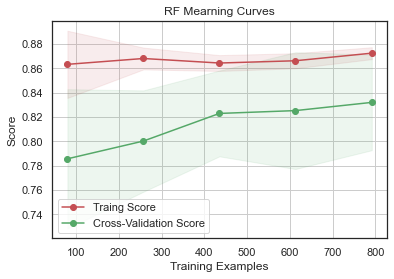

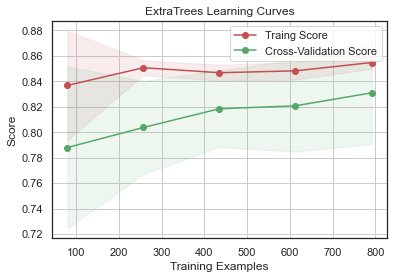

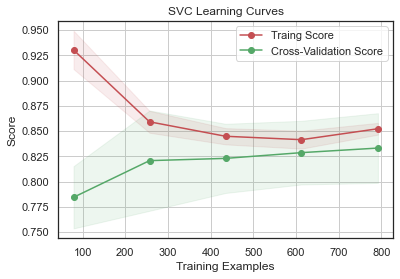

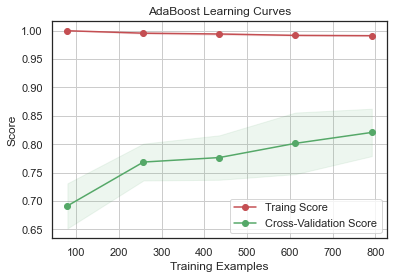

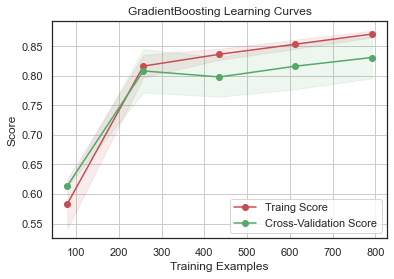

In [66]:
# np.linspace(시작값, 끝값, 갯수) 갯수 안쓰면 50개
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    # 그래프에 격자 표시 넣기
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Traing Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
    plt.legend(loc='best')
    
    return plt

plot_learning_curve(gsRFC.best_estimator_, 'RF Mearning Curves', X_train, Y_train, cv=kfold)
plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees Learning Curves", X_train, Y_train, cv=kfold)
plot_learning_curve(gsSVMC.best_estimator_,"SVC Learning Curves", X_train, Y_train, cv=kfold)
plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost Learning Curves", X_train, Y_train, cv=kfold)
plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting Learning Curves", X_train, Y_train, cv=kfold)

**GradientBoosting** 과 **AdaBoost** 에서 과적합의 경향을 보이고 **SVC** 와 **ExtraTrees** 는 *Training Score* 와 *Cross-Validation Score* 가 가까워서 예측을 더 일반화하는 것으로 보인다.  
#### 6.1.4 Feature importance of tree based classifiers
4개의 분류기에 대해 각각 어떠한 피쳐가 중요했는지에 대해 알아보자.

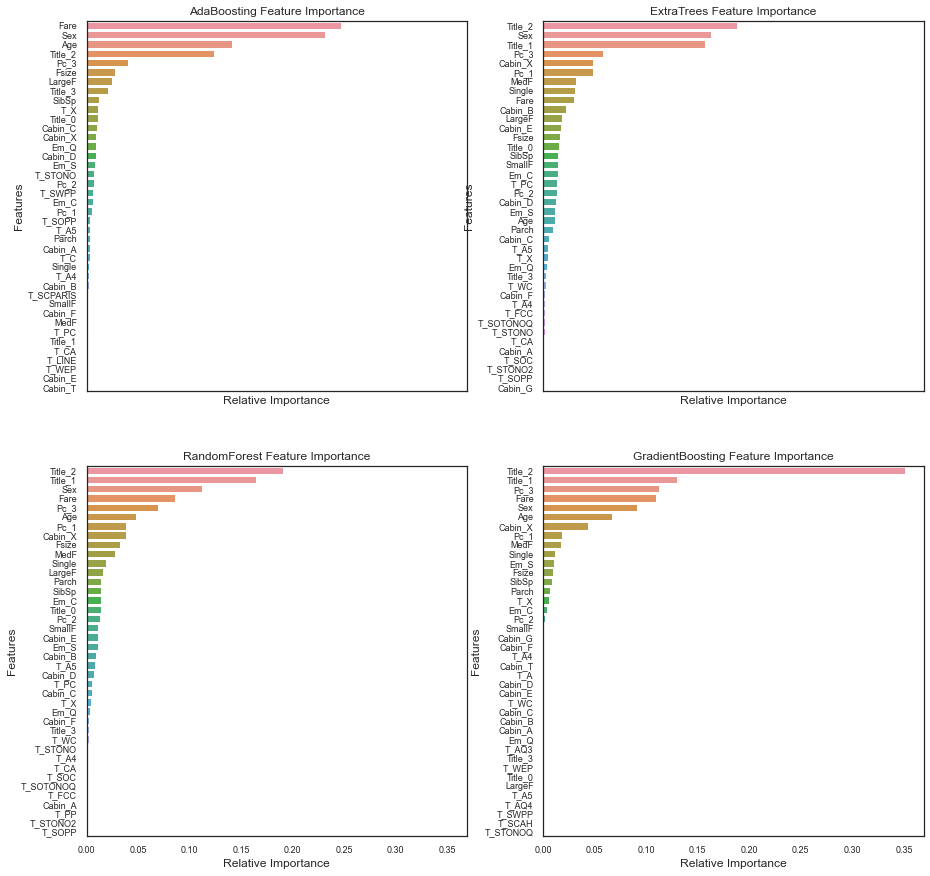

In [67]:
# sharex: 모든 서브플롯이 같은 x축 눈금을 사용하도록 함.
nrows = ncols = 2
f, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(15, 15))
names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]
nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40], x=classifier.feature_importances_[indices][:40], orient='h', ax=ax[row][col])
        g.set_xlabel('Relative Importance', fontsize=12)
        g.set_ylabel('Features', fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + ' Feature Importance')
        nclassifier += 1

4 종류의 분류기는 각기 다른 특징(Fare, Title_2)을 중요하게 생각한다. 하지만 모든 분류기에서 *Fare, Title_2(Miss~Mrs), Age, Sex* 등은 모두 높은 중요도를 가진다.  
여기까지 정리하면:
- Pc_1, Pc_2, Pc_3, Fare 는 승객들의 사회적 지위를 나타낸다.
- Sex, Title_2(Miss~Mrs), Title_3(Mr)는 성별을 나타낸다.
- Age, Title_1(Master)는 나이를 나타낸다.
- Fsize, LargeF, MedF, SmallF, Single은 가족의 크기를 나타낸다.  

위 4 종류 분류기의 중요성에 따르면 생존률은 선박 안의 위치보다 연령, 성별, 가족 규모, 사회적 지위와 더 연관이 있다.

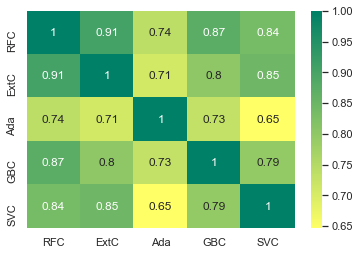

In [68]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name='RFC')
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)
sns.heatmap(ensemble_results.corr(), annot=True, cmap='summer_r')

**AdaBoost** 를 제외한 나머지 분류기들은 매우 큰 상관관계가 있다. **AdaBoost** 의 상관관계도 많이 낮은 것은 아니기에 다수결 분석을 진행할만 하다.  

### 6.2 Ensemble modeling
**VotingClassifier** 는 다수결 분류로 두가지 방법이 가능하다.(5가지 분류기가 있을때를 가정)
- hard voting: 1이라고 예측한 분류기가 3개, 0이라고 예측한 분류기가 2개라면 1을 채택한다. -> 과반수 투표
- soft voting: 각 분류기의 예측을 평균내어 예측 확률에 대한 평균이 높게 나오는 클래스를 최종 예측 클래스로 정한다.  

여기선 soft voting 방식을 사용한다.

In [69]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best), ('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best)], voting='soft', n_jobs=4)
votingC = votingC.fit(X_train, Y_train)

### 6.3 Prediction

In [70]:
test_Survived = pd.Series(votingC.predict(test), name='Survived')
results = pd.concat([IDtest, test_Survived], axis=1)
results.to_csv('titanic_with_ensemble_modeling.csv', index=False)